### 1. Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
import hdbscan
import geopandas as gpd
import contextily as ctx
from geopy.geocoders import Nominatim
from tqdm.notebook import tqdm
from geopy.extra.rate_limiter import RateLimiter

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn import tree

import sys
import os
sys.path.append(os.path.abspath('..'))
from datetime import datetime
from functions.shap_forceplots import clust_shap_force

### 2. Import zuigelingen

In [2]:
# Choose embedded space to work with
embedded_space = 'intersection'

# Load datasets
if embedded_space == 'intersection':
    X_zuigelingen_UMAP15 = np.load('../4_Data\Arrays\X_zuigelingen_partiallyvaccinated_UMAP15_intersection1.npy')
elif embedded_space == 'union':
    X_zuigelingen_UMAP15 = np.load('../4_Data\Arrays\X_zuigelingen_partiallyvaccinated_UMAP15_union1.npy')

y_zuigelingen = np.load('../4_Data/Arrays/y_zuigelingen.npy')

# Original variables
zuigelingen = pd.read_pickle('../4_Data/Pickles/zuigelingen.pkl')
X_zuigelingen_partiallyvaccinated = pd.read_pickle('../4_Data/Pickles/X_zuigelingen_partiallyvaccinated.pkl')
X_zuigelingen_vaccinated = pd.read_pickle('../4_Data/Pickles/X_zuigelingen_vaccinated.pkl')

# Split subset of X_zuigelingen for rows which were 'Vaccinated' in y_zuigelingen
zuigelingen = zuigelingen[y_zuigelingen == 1]

In [3]:
# Loop over every column name in a df
def column_cleaner(df):
    for column in df.columns:
        ## Remove categories
        # Get position of last capital letter by iterating backwards
        pos = 0
        for i in range(len(column)-1, 0, -1):
            if column[i].isupper() and (column[i-1].islower() or column[i-1] == '_'):
                pos = i
                break
        # If there is a capital letter
        if pos != 0 and column[-1] != '_':
            # Remove everything after the before capital letter
            df.rename(columns={column: column[pos:]}, inplace=True)
        elif pos != 0 and column[-1] == '_':
            df.rename(columns={column: column[pos:] + '%'}, inplace=True)
    return df

# Manually set some other column names
def column_editor(df):
    df.rename(columns={'Inkomen_van_huishoudens40_huishoudens_met_laagste_inkomen_%': 'Huishoudens_laagste_landelijke_40%_huishoudensinkomens_%'}, inplace=True)
    df.rename(columns={'Inkomen_van_huishoudens20_huishoudens_met_hoogste_inkomen_%': 'Huishoudens_hoogste_landelijke_20%_huishoudensinkomens_%'}, inplace=True)
    df.rename(columns={'Huishoudens_tot_110_van_sociaal_minimum_%': 'Huishoudens_tot_110%_van_sociaal_minimum_%'}, inplace=True)
    df.rename(columns={'Huishoudens_tot_120_van_sociaal_minimum_%': 'Huishoudens_tot_120%_van_sociaal_minimum_%'}, inplace=True)
    df.rename(columns={'Personenautos_per_huishouden_per_huishouden': 'Personenautos_per_huishouden'}, inplace=True)
    df.rename(columns={'stedelijkheid_1.0': 'zeer_sterk_stedelijk'}, inplace=True)
    df.rename(columns={'stedelijkheid_2.0': 'sterk_stedelijk'}, inplace=True)
    df.rename(columns={'stedelijkheid_3.0': 'matig_stedelijk'}, inplace=True)
    df.rename(columns={'stedelijkheid_4.0': 'weinig_stedelijk'}, inplace=True)
    df.rename(columns={'stedelijkheid_5.0': 'niet_stedelijk'}, inplace=True)
    return df

In [ ]:
# Clean notvaccinated
column_cleaner(X_zuigelingen_partiallyvaccinated)
column_editor(X_zuigelingen_partiallyvaccinated)

# Clean vaccinated
column_cleaner(X_zuigelingen_vaccinated)
column_editor(X_zuigelingen_vaccinated)

,gemiddelde_woz_waarde_woning,Nettoarbeidsparticipatie_%,Huishoudens_laagste_landelijke_40%_huishoudensinkomens_%,Huishoudens_hoogste_landelijke_20%_huishoudensinkomens_%,Huishoudens_met_een_laag_inkomen_%,Huish_onder_of_rond_sociaal_minimum_%,Huishoudens_tot_110%_van_sociaal_minimum_%,Huishoudens_tot_120%_van_sociaal_minimum_%,Mediaan_vermogen_van_particuliere_huish_x_1_000_euro,Percentage_jongeren_met_jeugdzorg_%,...,Migrant,Nederlands,CBS_indeling_nan,Toestemming_0.0,Toestemming_1.0,Toestemming_nan,Tweeling,Geslacht=mannelijk,Gevaccineerd_ouder1,Gevaccineerd_ouder2
0,518.0,66.0,25.300,37.30,2.60,3.600,5.700,8.10,476.400,9.20,...,False,True,False,False,True,False,False,True,True,True
1,306.0,46.0,68.800,7.60,8.20,14.800,22.100,31.90,7.700,10.60,...,False,True,False,False,True,False,False,False,False,False
3,307.0,66.0,30.200,13.80,1.80,2.400,2.900,4.20,193.600,12.10,...,False,True,False,False,True,False,False,False,True,True
4,328.0,73.0,26.800,32.40,2.60,3.700,6.200,8.30,223.700,11.10,...,False,True,False,False,True,False,False,True,True,True
5,372.0,78.0,14.300,38.10,3.00,2.300,3.300,3.80,256.400,11.20,...,False,True,False,False,True,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5379,336.0,76.0,20.800,36.60,1.70,0.700,1.200,2.20,365.800,6.50,...,False,True,False,False,True,False,False,False,True,True
5380,264.0,67.0,25.400,18.90,2.40,3.400,4.700,6.50,163.800,13.60,...,False,False,True,False,True,False,False,True,True,True
5381,336.0,72.0,38.100,23.20,2.30,2.700,4.900,8.00,287.200,11.30,...,False,True,False,False,True,False,False,False,True,True
5382,280.0,64.0,48.500,10.40,5.50,7.100,11.700,16.40,37.100,12.90,...,False,True,False,False,True,False,False,True,False,False


### 3. Clustering

In [ ]:
# Save hyperparameters
min_cluster_size = 25
min_samples = 10

# Fit HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
hdb.fit(X_zuigelingen_UMAP15)
print(hdb.labels_)

[ 0  0  0  0  0  0  0  1  0  0  1  1  0  0  0  1  1  1  0  0  0  1  0  0
  0  0  1  0  0  1  0 -1  0 -1  0  0  1  0  1  1  1  1  0  1  0  1  0  0
  1  0  1 -1 -1  0  1  0  0  1  1  1  1  1  1  1  0  0  0  0  1  0  0  1
  1  1  0  1  1  0  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  1  0  0  0
  1  0  0  1 -1  1  0  1  1  1  0  1  0  0  1  1  1  0  0  0  1  0  1  0
  0  1  1  0  0  0  0  0  0 -1  1  1  1  1  0  1  0  1  0  0  0  1  0 -1
  1 -1  1  1  1  0  1  1  0  0 -1  1  1  0 -1 -1  1  0  1  0  1 -1  0  0
  1  1  0  1  0  0  0  1  1  1  0  0  1  1  1  1  1  1  0  0  0  1  0  1
  0  0  0  1  0  1  1  1  0  0  0  1  0  0  1  0  0  0  0  0  0 -1  1  1
  1  0  0  0  1  1  0  1  1 -1  0  1  1  0  1  0  1  0  0  0  1  1  0  1
  0  0  0  1  1  0 -1  1  0  1  0  1  0  0  1  0  1  0  1  1  0  1  1 -1
  0  0  0]


In [6]:
# Calculate silhouette score excluding noise cluster
if -1 in hdb.labels_:
    silhouette = silhouette_score(X_zuigelingen_UMAP15[hdb.labels_ != -1], hdb.labels_[hdb.labels_ != -1])
else:
    silhouette = silhouette_score(X_zuigelingen_UMAP15, hdb.labels_)

print(f'The silhouette score is: {silhouette}')

The silhouette score is: 0.6545616984367371


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


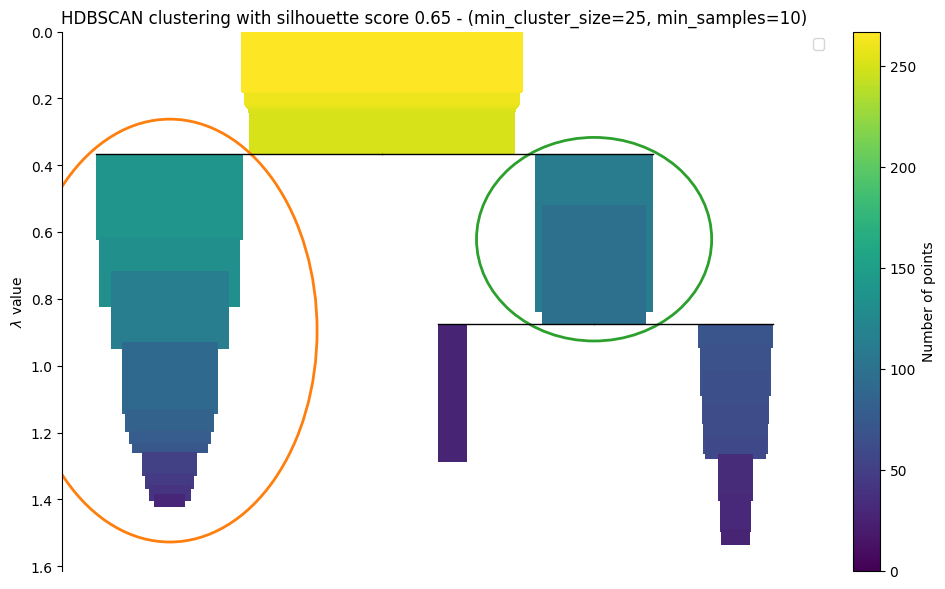

In [7]:
# If -1 is in the labels, begin with second color in palette
if -1 in hdb.labels_:
    plt.figure(figsize=(12, 7))
    plt.title(f'HDBSCAN clustering with silhouette score {silhouette:.2f} - (min_cluster_size={min_cluster_size}, min_samples={min_samples})')
    hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette()[1:])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
else:
    plt.figure(figsize=(12, 7))
    plt.title(f'HDBSCAN clustering with silhouette score {silhouette:.2f} - (min_cluster_size={min_cluster_size}, min_samples={min_samples})')
    hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [8]:
# Plot sns.color_palette() to see the colors used in the plot
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [9]:
# Get amount of unique values in an array
unique, counts = np.unique(hdb.labels_, return_counts=True)
print(dict(zip(unique, counts)))

{-1: 17, 0: 139, 1: 111}


In [10]:
# Calculate the amount of clusters
if -1 in hdb.labels_:
    n_clusters = len(np.unique(hdb.labels_)) - 1 # Subtract 1 because of the noise cluster
else:
    n_clusters = len(np.unique(hdb.labels_))
print(f'The amount of clusters derived is: {n_clusters}')

The amount of clusters derived is: 2


In [11]:
# Calculate silhouette score excluding noise cluster
if -1 in hdb.labels_:
    silhouette = silhouette_score(X_zuigelingen_UMAP15[hdb.labels_ != -1], hdb.labels_[hdb.labels_ != -1])
else:
    silhouette = silhouette_score(X_zuigelingen_UMAP15, hdb.labels_)

print(f'The silhouette score is: {silhouette}')

The silhouette score is: 0.6545616984367371


### 4. Interpretation of clustering results

#### 4.1 Comparison of measures of central tendency

In [12]:
# Save cluster labels as y
y_clusters_zuigelingen = hdb.labels_

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_zuigelingen_partiallyvaccinated, y_clusters_zuigelingen, test_size=0.3, random_state=42)

In [14]:
shap.initjs()

In [15]:
# Initialize the Random Forest Classifier
clf_rf = RandomForestClassifier(random_state=42)

# Train the classifier
clf_rf.fit(X_train, y_train)

# Make predictions
y_pred = clf_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         4
           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        30

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81

Confusion Matrix:
[[ 4  0  0]
 [ 0 47  0]
 [ 0  0 30]]


In [16]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(clf_rf)
shap_values = explainer.shap_values(X_train)

In [17]:
le_classes = np.unique(y_clusters_zuigelingen)

In [18]:
X_train.iloc[23]

gemiddelde_woz_waarde_woning                                525.0
Nettoarbeidsparticipatie_%                                   71.0
Huishoudens_laagste_landelijke_40%_huishoudensinkomens_%     17.4
Huishoudens_hoogste_landelijke_20%_huishoudensinkomens_%     43.9
Huishoudens_met_een_laag_inkomen_%                            1.0
                                                            ...  
Toestemming_nan                                             False
Tweeling                                                    False
Geslacht=mannelijk                                           True
Gevaccineerd_ouder1                                          True
Gevaccineerd_ouder2                                          True
Name: 4498, Length: 82, dtype: object

In [19]:
clust_shap_force(clf_rf, 23,
                 X_train, y_train,
                 explainer,
                 shap_values,
                 le_classes,
                 classes='all')

***************************************************
Ground Truth Label: 0 - -1

Model Prediction:  [0] - -1 -- Correct!
***************************************************


-1 Class (0)



0 Class (1)



1 Class (2)


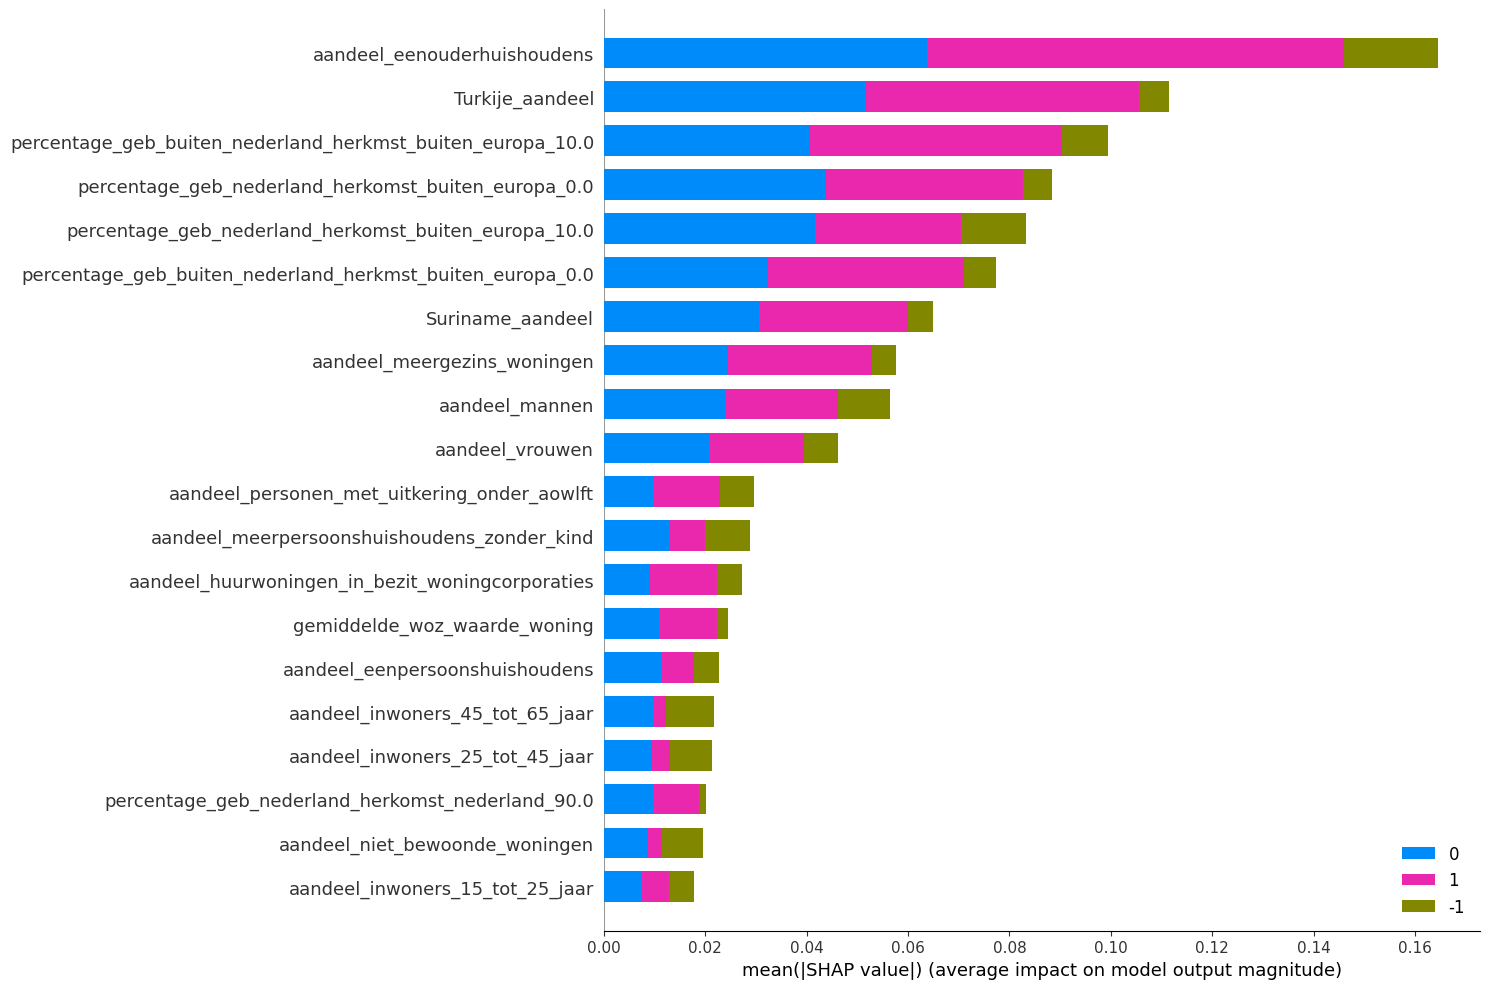

In [20]:
# Split the array into a list of arrays, one for each class
multi_shap_vals = [shap_values[:, :, i] for i in range(shap_values.shape[2])]

# Plot the SHAP values with feature names
shap.summary_plot(multi_shap_vals, X_train.values, plot_type='bar', class_names=le_classes, feature_names=X_train.columns, plot_size=(15, 10))

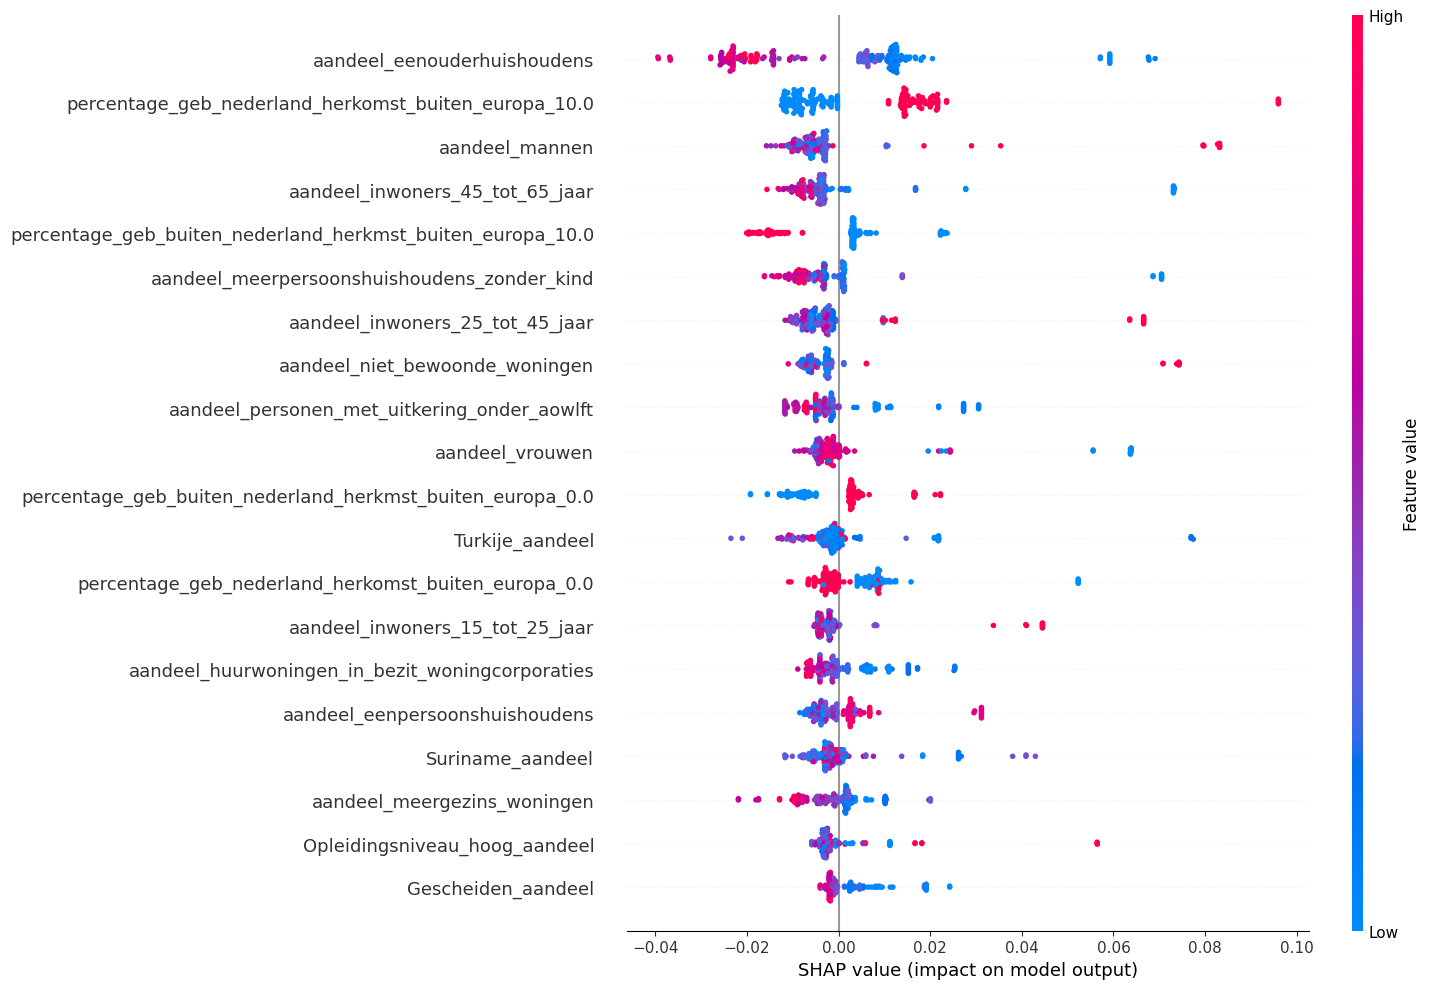

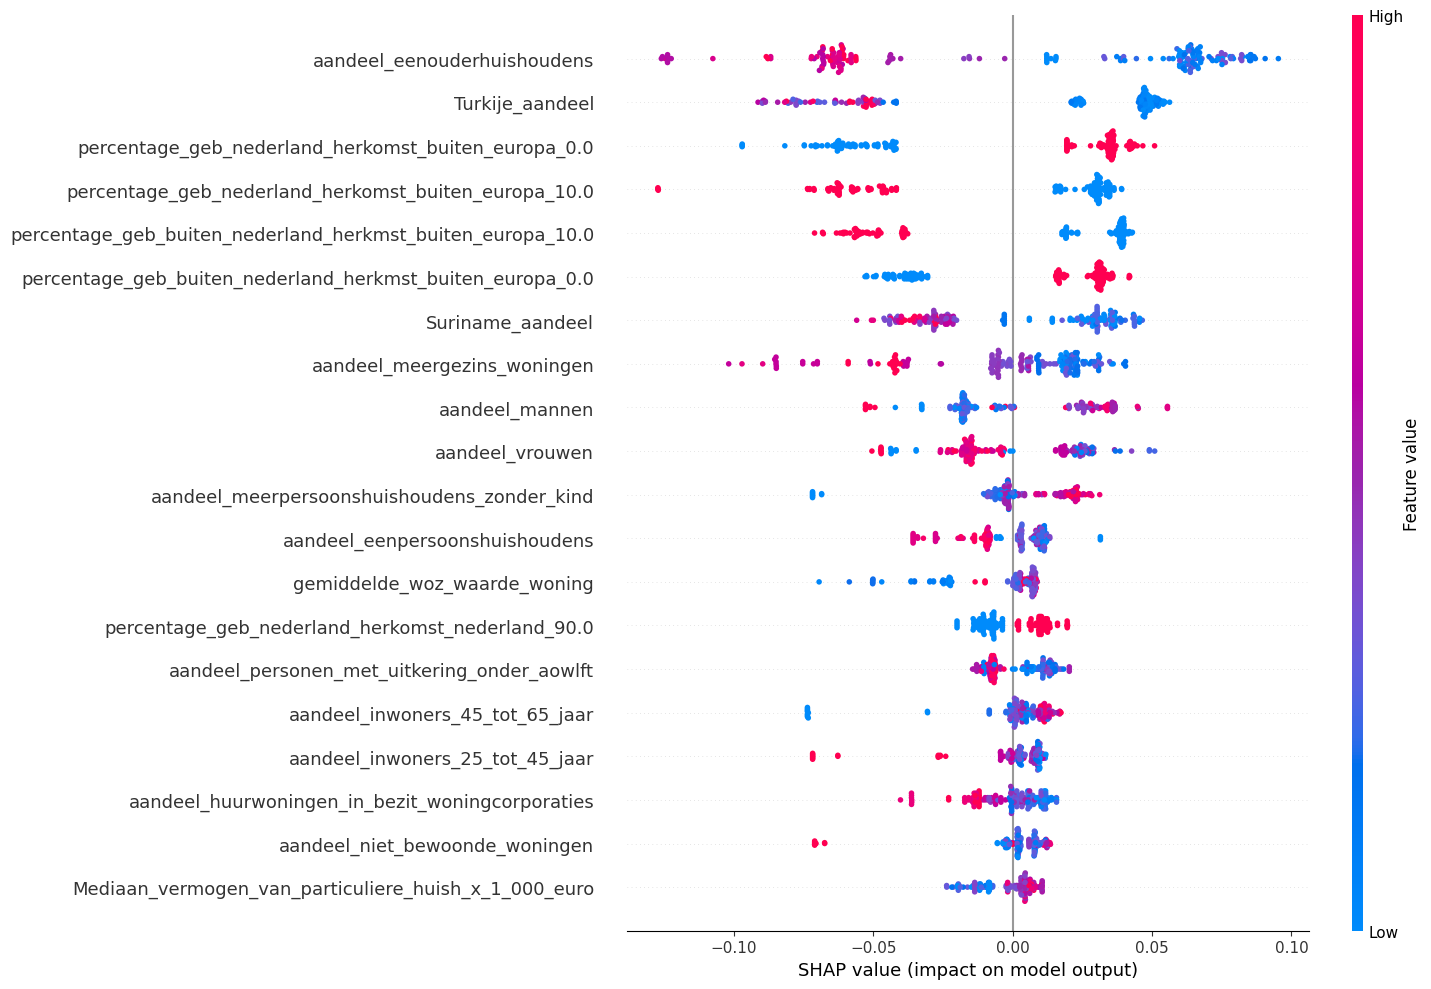

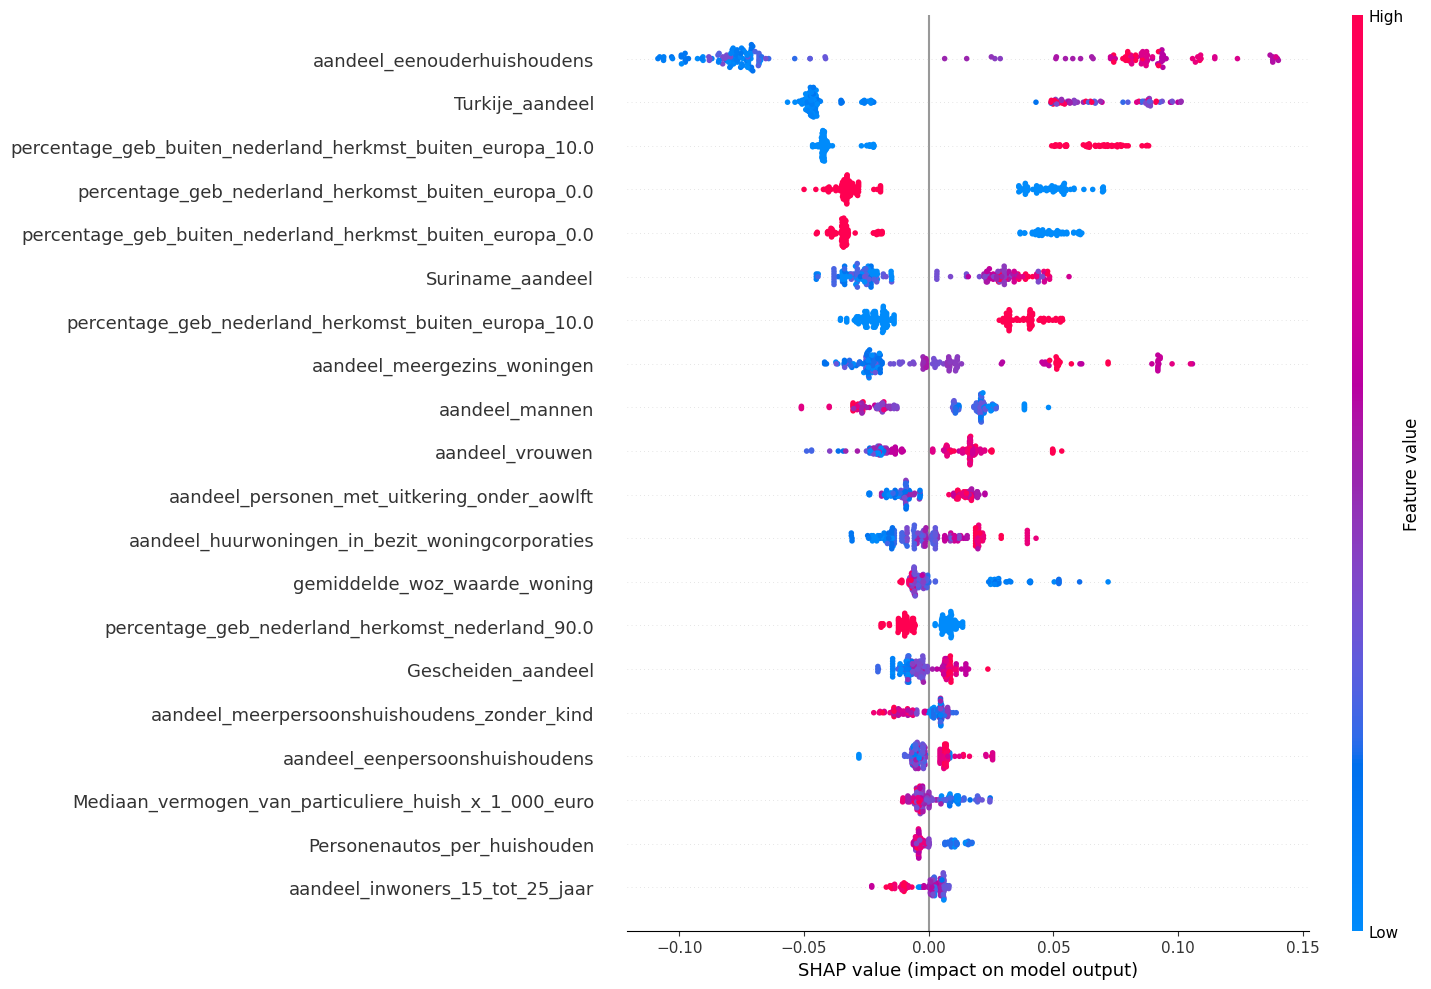

In [21]:
# Print summary plot per cluster
for cluster in range(len(le_classes)):
    shap.summary_plot(shap_values[:, :, cluster], X_train, feature_names=X_train.columns, plot_size=(15, 10))

#### 4.2 Neighbourhood plots

In [22]:
# Take only relevant columns
zuigelingen_buurt = zuigelingen[['BuurtCode']]

# Add the cluster labels to the original dataset
zuigelingen_buurt['Cluster_label'] = hdb.labels_

# Get all unique Cluster_label values
all_cluster_labels = zuigelingen_buurt['Cluster_label'].unique()

# Calculate the percentages of 'Cluster_label' per unique CBS_Buurtcode_BRP
buurt_percentages = zuigelingen_buurt.groupby('BuurtCode')['Cluster_label'].value_counts(normalize=True).unstack().fillna(0)

# Reindex to ensure all unique Cluster_label values are included as columns
buurt_percentages = buurt_percentages.reindex(columns=all_cluster_labels, fill_value=0)

# Reset index
buurt_percentages = buurt_percentages.reset_index()

# Reading GeoPackage file
cbs_df = gpd.read_file('../4_Data/Polygons/buurten_2023_v1.shp')

# Replace every -99997 with NaN
cbs_df = cbs_df.replace(-99997, np.nan)

# From every row in 'BU_CODE' remove the first two characters
cbs_df['BU_CODE'] = cbs_df['BU_CODE'].astype(str).str[2:]

# Define list of relevant municipalities
municipalities = ['Alphen-Chaam',
                  'Altena',
                  'Baarle-Nassau',
                  'Breda',
                  'Drimmelen',
                  'Etten-Leur',
                  'Geertruidenberg',
                  'Halderberge',
                  'Oosterhout',
                  'Zundert']

# Filter the df_pc4 to only include the relevant municipalities
cbs_df = cbs_df[cbs_df['GM_NAAM'].isin(municipalities)]

# Merge polygons with percentages for all clusters
gdf = cbs_df.merge(buurt_percentages[['BuurtCode'] + list(range(n_clusters))], left_on='BU_CODE', right_on='BuurtCode', how='left')

#### 4.3 Comparison of central tendency

In [23]:
# Take only float64 and int64 columns
X_zuigelingen_continuous = X_zuigelingen_partiallyvaccinated.select_dtypes(include=['float64', 'int64'])

# Add 'Zuigelingen_status' to the DataFrame
X_zuigelingen_continuous['Cluster'] = y_clusters_zuigelingen

# Group X_zuigelingen by Zuigelingen_status and calculate mean
grouped_continuous = X_zuigelingen_continuous.groupby('Cluster').mean()

# Transpose the DataFrame
grouped_continuous = grouped_continuous.T

# Add the calculated measures of central tendency as new columns to grouped_continuous
grouped_continuous['Gemiddelde (deels gevaccineerden)'] = X_zuigelingen_continuous.mean()
grouped_continuous['Mediaan (deels gevaccineerden)'] = X_zuigelingen_continuous.median()
grouped_continuous['SD (deels gevaccineerden)'] = X_zuigelingen_continuous.std()

# Add the calculated box plot statistics as new columns to grouped_continuous
grouped_continuous['Q1 (deels gevaccineerden)'] = X_zuigelingen_continuous.quantile(0.25)
grouped_continuous['Q3 (deels gevaccineerden)'] = X_zuigelingen_continuous.quantile(0.75)
grouped_continuous['IQR (deels gevaccineerden)'] = grouped_continuous['Q3 (deels gevaccineerden)'] - grouped_continuous['Q1 (deels gevaccineerden)']
grouped_continuous['Ondergrens uitschieters (deels gevaccineerden)'] = grouped_continuous['Q1 (deels gevaccineerden)'] - 1.5 * grouped_continuous['IQR (deels gevaccineerden)']
grouped_continuous['Bovengrens uitschieters (deels gevaccineerden)'] = grouped_continuous['Q3 (deels gevaccineerden)'] + 1.5 * grouped_continuous['IQR (deels gevaccineerden)']

# Add X_zuigelingen_vaccinated means and medians to grouped_continuous
grouped_continuous['Gemiddelde (gevaccineerden)'] = X_zuigelingen_vaccinated.select_dtypes(include=['float64', 'int64']).mean()
grouped_continuous['Mediaan (gevaccineerden)'] = X_zuigelingen_vaccinated.select_dtypes(include=['float64', 'int64']).median()
grouped_continuous['SD (gevaccineerden)'] = X_zuigelingen_vaccinated.select_dtypes(include=['float64', 'int64']).std()
grouped_continuous

Cluster,-1,0,1,Gemiddelde (deels gevaccineerden),Mediaan (deels gevaccineerden),SD (deels gevaccineerden),Q1 (deels gevaccineerden),Q3 (deels gevaccineerden),IQR (deels gevaccineerden),Ondergrens uitschieters (deels gevaccineerden),Bovengrens uitschieters (deels gevaccineerden),Gemiddelde (gevaccineerden),Mediaan (gevaccineerden),SD (gevaccineerden)
gemiddelde_woz_waarde_woning,366.882353,355.827338,298.810811,332.827715,320.000000,58.315388,301.000000,340.000000,39.000000,242.500000,398.500000,336.590780,323.000000,57.116428
Nettoarbeidsparticipatie_%,70.529412,67.755396,63.819820,66.295880,67.000000,5.088549,64.000000,69.000000,5.000000,56.500000,76.500000,67.030486,67.000000,4.718167
Huishoudens_laagste_landelijke_40%_huishoudensinkomens_%,30.929412,30.245050,38.624324,33.772142,32.200000,10.502445,25.700000,39.200000,13.500000,5.450000,59.450000,31.943366,31.600000,9.609127
Huishoudens_hoogste_landelijke_20%_huishoudensinkomens_%,29.476471,26.299705,18.309009,23.179996,23.000000,9.361035,17.100000,29.650000,12.550000,-1.725000,48.475000,24.400270,23.700000,9.305635
Huishoudens_met_een_laag_inkomen_%,2.900000,2.536410,4.293694,3.290116,2.900000,1.846725,2.200000,4.000000,1.800000,-0.500000,6.700000,2.917007,2.600000,1.598692
Huish_onder_of_rond_sociaal_minimum_%,3.805882,3.336237,6.264865,4.583659,3.700000,2.719812,2.900000,5.500000,2.600000,-1.000000,9.400000,4.008490,3.600000,2.269558
Huishoudens_tot_110%_van_sociaal_minimum_%,6.211765,5.361432,9.569369,7.164940,6.200000,3.995204,4.800000,8.550000,3.750000,-0.825000,14.175000,6.262393,5.400000,3.405949
Huishoudens_tot_120%_van_sociaal_minimum_%,8.064706,7.478460,12.647748,9.664816,8.400000,5.300717,6.200000,11.700000,5.500000,-2.050000,19.950000,8.523090,7.500000,4.497382
Mediaan_vermogen_van_particuliere_huish_x_1_000_euro,248.047059,283.822676,135.305405,219.801693,202.200000,130.394300,139.500000,264.850000,125.350000,-48.525000,452.875000,240.835025,232.100000,130.446979
Percentage_jongeren_met_jeugdzorg_%,8.305882,9.418381,11.867748,10.365824,10.100000,2.490277,8.500000,12.200000,3.700000,2.950000,17.750000,10.324394,10.337000,2.344457


In [24]:
# Take only boolean columns
X_zuigelingen_categories = X_zuigelingen_partiallyvaccinated.select_dtypes(include=['boolean', 'category'])
X_zuigelingen_vaccinated = X_zuigelingen_vaccinated.select_dtypes(include=['boolean', 'category'])

# Add 'Zuigelingen_status' to the DataFrame
X_zuigelingen_categories['Cluster'] = y_clusters_zuigelingen

# Dictionary to store combined DataFrames
combined_dfs = {}

# Loop over each categorical column
for col in X_zuigelingen_categories.columns:
    if col != 'Cluster':
        # Group by Zuigelingen_status and the current categorical column
        grouped = X_zuigelingen_categories.groupby(['Cluster', col]).size().unstack().T

        # Calculate percentages
        grouped_pct = grouped.div(grouped.sum(axis=0), axis=1) * 100
        
        # Rename percentage columns to include '(%)'
        grouped_pct.columns = [f"{col} (%)" for col in grouped_pct.columns]

        # Calculate total counts and percentages across all clusters
        total_counts = grouped.sum(axis=1)
        total_pct = total_counts / total_counts.sum() * 100
        
        # Calculate total counts and percentages in X_zuigelingen_vaccinated
        total_counts_vaccinated = X_zuigelingen_vaccinated[col].value_counts()
        total_pct_vaccinated = total_counts_vaccinated / total_counts_vaccinated.sum() * 100
        
        # Add total counts and percentages to the DataFrame
        grouped['Totaal (niet gevaccineerden)'] = total_counts
        grouped_pct['Totaal (niet gevaccineerden) (%)'] = total_pct
        
        # Add total counts and percentages in X_zuigelingen_vaccinated to the DataFrame
        grouped['Totaal (gevaccineerden)'] = total_counts_vaccinated
        grouped_pct['Totaal (gevaccineerden) (%)'] = total_pct_vaccinated
        
        # Concatenate counts and percentages horizontally
        combined = pd.concat([grouped, grouped_pct], axis=1)
        
        # Add a new level to the index to preserve the original variable names
        combined.index = pd.MultiIndex.from_product([[col], combined.index])
        
        # Store the combined DataFrame in the dictionary
        combined_dfs[col] = combined

# Concatenate all combined DataFrames vertically
grouped_categories = pd.concat(combined_dfs.values(), axis=0)
grouped_categories

-1      0     1  \
percentage_geb_nederland_herkomst_nederland_70.0 False  17.0  133.0  81.0   
                                                 True    NaN    6.0  30.0   
percentage_geb_nederland_herkomst_nederland_80.0 False  10.0  124.0  43.0   
                                                 True    7.0   15.0  68.0   
percentage_geb_nederland_herkomst_nederland_90.0 False   7.0   21.0  98.0   
...                                                      ...    ...   ...   
Geslacht=mannelijk                               True    6.0   69.0  54.0   
Gevaccineerd_ouder1                              False  15.0   81.0  71.0   
                                                 True    2.0   58.0  40.0   
Gevaccineerd_ouder2                              False  14.0   75.0  70.0   
                                                 True    3.0   64.0  41.0   

                                                        Totaal (niet gevaccineerden)  \
percentage_geb_nederland_herkomst_nederland_70.0 False                         231.0   
                                                 True                           36.0   
percentage_geb_nederland_herkomst_nederland_80.0 False                         177.0   
                                                 True                           90.0   
percentage_geb_nederland_herkomst_nederland_90.0 False                         126.0   
...                                                                              ...   
Geslacht=mannelijk                               True                          129.0   
Gevaccineerd_ouder1                              False                         167.0   
                                                 True                          100.0   
Gevaccineerd_ouder2                              False                         159.0   
                                                 True                          108.0   

                                                        Totaal (gevaccineerden)  \
percentage_geb_nederland_herkomst_nederland_70.0 False                     4421   
                                                 True                       478   
percentage_geb_nederland_herkomst_nederland_80.0 False                     3077   
                                                 True                      1822   
percentage_geb_nederland_herkomst_nederland_90.0 False                     2307   
...                                                                         ...   
Geslacht=mannelijk                               True                      2490   
Gevaccineerd_ouder1                              False                     1351   
                                                 True                      3548   
Gevaccineerd_ouder2                              False                     1343   
                                                 True                      3556   

                                                            -1 (%)      0 (%)  \
percentage_geb_nederland_herkomst_nederland_70.0 False  100.000000  95.683453   
                                                 True          NaN   4.316547   
percentage_geb_nederland_herkomst_nederland_80.0 False   58.823529  89.208633   
                                                 True    41.176471  10.791367   
percentage_geb_nederland_herkomst_nederland_90.0 False   41.176471  15.107914   
...                                                            ...        ...   
Geslacht=mannelijk                               True    35.294118  49.640288   
Gevaccineerd_ouder1                              False   88.235294  58.273381   
                                                 True    11.764706  41.726619   
Gevaccineerd_ouder2                              False   82.352941  53.956835   
                                                 True    17.647059  46.043165   

                                                            1 (%)  \
percentage_geb_nederland_herkomst_ned

#### 4.4 Structure and save results

In [25]:
# Print general info
print(f'In de data zijn {n_clusters} clusters gevonden. Het cluster waartoe een individu behoort kan op basis van zijn of haar kenmerken voorspeld worden met een \'accuracy\' van {accuracy:.2f}.')
# Example value for 'today'
today = datetime.now().strftime('%Y-%m-%d')
# Make target folder to place plots
os.makedirs(f'../9_Results\\Zuigelingen\\Partially_vaccinated\\15D\\{today}_Clusters')

In de data zijn 2 clusters gevonden. Het cluster waartoe een individu behoort kan op basis van zijn of haar kenmerken voorspeld worden met een 'accuracy' van 1.00.


In [26]:
# Split the array into a list of arrays, one for each class
multi_shap_vals = [shap_values[:, :, i] for i in range(shap_values.shape[2])]

# Plot the SHAP values with feature names
shap.summary_plot(multi_shap_vals, X_train.values, plot_type='bar', class_names=le_classes, feature_names=X_train.columns, plot_size=(15, 10), show=False)
plt.title('SHAP Summary Plot')
plt.savefig(f'../9_Results\\Zuigelingen\\Partially_vaccinated\\15D\\{today}_Clusters\\SHAP_summary_plot.jpg', dpi=300, bbox_inches='tight')
plt.close()

# Save grouped_continuous and grouped_categories to a .xlsx file on two separate sheets
with pd.ExcelWriter(f'../9_Results\\Zuigelingen\\Partially_vaccinated\\15D\\{today}_Clusters\\Clusterkenmerken.xlsx') as writer:
    grouped_continuous.to_excel(writer, sheet_name='Kenmerken_continu')
    grouped_categories.to_excel(writer, sheet_name='Kenmerken_categorisch')

# If -1 is in the labels, begin with second color in palette
if -1 in hdb.labels_:
    plt.figure(figsize=(12, 7))
    plt.title(f'HDBSCAN clustering - (min_cluster_size={min_cluster_size}, min_samples={min_samples})')
    hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette()[1:])
    plt.savefig(f'../9_Results\\Zuigelingen\\Partially_vaccinated\\15D\\{today}_Clusters\\HDBSCAN_tree.jpg', dpi=300, bbox_inches='tight')
    plt.close()
else:
    plt.figure(figsize=(12, 7))
    plt.title(f'HDBSCAN clustering - (min_cluster_size={min_cluster_size}, min_samples={min_samples})')
    hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    plt.savefig(f'../9_Results\\Zuigelingen\\Partially_vaccinated\\15D\\{today}_Clusters\\HDBSCAN_tree.jpg', dpi=300, bbox_inches='tight')
    plt.close()

# Print summary plot per cluster
for cluster in range(1, n_clusters+1):

    # Make target folder to place plots
    os.makedirs(f'../9_Results\\Zuigelingen\\Partially_vaccinated\\15D\\{today}_Clusters\\Cluster_{cluster}')

     # Calculate shap dim
    if -1 in y_clusters_zuigelingen:
        cluster_dim = cluster
    else:
        cluster_dim = cluster - 1
    
    # Plot the SHAP summary plot
    shap.summary_plot(shap_values[:, :, cluster_dim], X_train, feature_names=X_train.columns, plot_size=(15, 10), show=False, max_display=15)
    plt.title(f'SHAP cluster {cluster} plot')
    plt.savefig(f'../9_Results\\Zuigelingen\\Partially_vaccinated\\15D\\{today}_Clusters\\Cluster_{cluster}\\SHAP_cluster_plot.jpg', dpi=300,  bbox_inches='tight')
    plt.close()

    # Plot neighbourhoods
    cmap = mcolors.LinearSegmentedColormap.from_list('unidirectional', ['lightcoral', 'darkred'])
    gdf.plot(column=cluster-1,
            cmap=cmap,
            legend=True)
    plt.axis('off')
    plt.title(f'Deels-gevaccineerden per buurt - Cluster {cluster} (*100%)')
    plt.savefig(f'../9_Results\\Zuigelingen\\Partially_vaccinated\\15D\\{today}_Clusters\\Cluster_{cluster}\\Neighbourhoods.jpg', dpi=300, bbox_inches='tight')
    plt.close()